# Environment Setup

Now let's really begin with this tutorial!

To start working with Flower, very little is required once you have activated your Python environment (e.g. via `conda`, `virtualenv`, `pyenv`, etc). If you are running this code on Colab, there is really nothing to do except to install Flower and other dependencies. The steps below have been verified to run in Colab. Let's first, install Flower, then the ML framework of your choice and extra dependencies you might want to use.

## Installing Flower

You can install flower very conveniently from `pip`:

In [1]:
# depending on your shell, you might need to add `\` before `[` and `]`.
!pip install -q flwr[simulation]

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pyopenssl 23.2.0 requires cryptography!=40.0.0,!=40.0.1,<42,>=38.0.0, but you have cryptography 42.0.8 which is incompatible.

[notice] A new release of pip is available: 23.1.2 -> 24.1.1
[notice] To update, run: pip install --upgrade pip


We will be using the _simulation_ model in Flower, which allows you to run a large number of clients without the overheads of manually managing devices. This is achieved via the `Virtual Client Engine`, the core component that runs [FL Simulations](https://flower.ai/docs/framework/how-to-run-simulations.html) with Flower. With simulation, you can dynamically scale your experiments whether you run the code on your laptop, a machine with a single GPU, a server with multiple GPUs os even on a cluster with multiple servers. The `Virtual Client Engine` handles everything transparently and it allows you to specify how many resources (e.g. CPU cores, GPU VRAM) should be assigned to each virtual client.

## Install your ML framework

Flower is agnostic to your choice of ML Framework. Flower works with `PyTorch`, `Tensorflow`, `NumPy`, `🤗 Transformers`, `MXNet`, `JAX`, `scikit-learn`, `fastai`, `Pandas`. Flower also supports all major platforms: `iOS`, `Android` and plain `C++`. You can find a _quickstart- example for each of the above in the [Flower Repository](https://github.com/adap/flower/tree/main/examples) inside the `examples/` directory. And check the [Flower Documentation](https://flower.ai/docs/) for even more learning materials.


In [ ]:
# you might see a warning after running the command below, this can be ignored
# if you are running this outside Colab, you probably need to adjust the command below
!pip install torch==1.13.1+cpu torchvision==0.14.1+cpu torchaudio==0.13.1 --extra-index-url https://download.pytorch.org/whl/cpu

We are going to install some other dependencies you are likely familiar with. We'll use these to make plots.

In [ ]:
!pip install matplotlib

In [4]:
!pwd

/gpfs/home4/aduah/flower


## Created directory suitable for loading

##### UNCOMMENT BELOW IF YOU WANT TO TRAIN YOUR OWN IMAGE DATASET. FOLLOWING THE STEPS WILL MAKE YOU CREATE A FORMAT SUITABLE FOR FLOWER. WE USE A BIGGER SAMPLE OF COVID-19 AS AN EXAMPLE

Format: https://huggingface.co/docs/datasets/image_dataset \
Dataset: https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database/data

In [5]:
import os
import shutil

#### We left out the third folder "Long_Opacity".

In [ ]:
# If download from the source uncomment the next block and make your custom folder
# os.makedirs('./COVID19-BIG/train/Covid')
# os.makedirs('./COVID19-BIG/train/Normal')
# os.makedirs('./COVID19-BIG/train/Viral Pneumonia')

# COVID_PATH = './COVID19-BIG/train/Covid'
# NORMAL_PATH = './COVID19-BIG/train/Normal'
# VIRAL_PATH = './COVID19-BIG/train/Viral Pneumonia'


In [ ]:
# for image in os.listdir('/Users/allan/dataset/COVID-19_Radiography_Dataset/COVID/images'):
#     shutil.copy(os.path.join('/Users/allan/dataset/COVID-19_Radiography_Dataset/COVID/images', image), os.path.join(COVID_PATH, image))

# for image in os.listdir('/Users/allan/dataset/COVID-19_Radiography_Dataset/Normal/images'):
#     shutil.copy(os.path.join('/Users/allan/dataset/COVID-19_Radiography_Dataset/Normal/images', image), os.path.join(NORMAL_PATH, image))

# for image in os.listdir('/Users/allan/dataset/COVID-19_Radiography_Dataset/Viral Pneumonia/images'):
#     shutil.copy(os.path.join('/Users/allan/dataset/COVID-19_Radiography_Dataset/Viral Pneumonia/images', image), os.path.join(VIRAL_PATH, image))


In [ ]:
#check if everything was copied in directory
# directory_path1 = COVID_PATH
# directory_path2 = NORMAL_PATH
# directory_path3 = VIRAL_PATH

# # Print the length of the list (number of files)
# print("Number of files in directory:", len(os.listdir(directory_path1)))
# print("Number of files in directory:", len(os.listdir(directory_path2)))
# print("Number of files in directory:", len(os.listdir(directory_path3)))


# Centralised training: the old way of doing ML

Let's begin by creating a simple (but complete) training loop as it is commonly done in centralised setups. Starting our tutorial in this way will allow us to very clearly identify which parts of a typical ML pipeline are common to both centralised and federated training and which ones are poles a part.

For this tutorial we'll design a image classification pipeline using a simple CNN model as the network to train. 


## A dataset

Let's begin by constructing the dataset.

##### Method 1: If you already have a structure like the 'Covid19-dataset' folder

In [4]:
# Not using paritioner !
from datasets import Dataset
from flwr_datasets import FederatedDataset
from datasets.utils.logging import disable_progress_bar
from datasets import load_dataset
from flwr_datasets.partitioner import IidPartitioner



dataset = load_dataset("imagefolder", data_dir="/gpfs/home4/aduah/flower/dataset/Covid19-dataset")
trainset = dataset['train']
testset = dataset['test']

Resolving data files:   0%|          | 0/251 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/66 [00:00<?, ?it/s]

##### Method 2: If you created the custom structure following the steps above

In [7]:
# dataset = load_dataset("imagefolder", data_dir="/gpfs/home4/aduah/flower/dataset/COVID19-BIG")
# train_test_split = dataset['train'].train_test_split(test_size=0.2, seed=42)
# trainset = train_test_split["train"]
# testset = train_test_split["test"]

### EDA

In [5]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import random
%matplotlib inline

print('train:', trainset)
print('test:', testset)
print('Image info:', trainset[0])

train: Dataset({
    features: ['image', 'label'],
    num_rows: 251
})
test: Dataset({
    features: ['image', 'label'],
    num_rows: 66
})
Image info: {'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=4248x3480 at 0x14D6A6C78150>, 'label': 0}


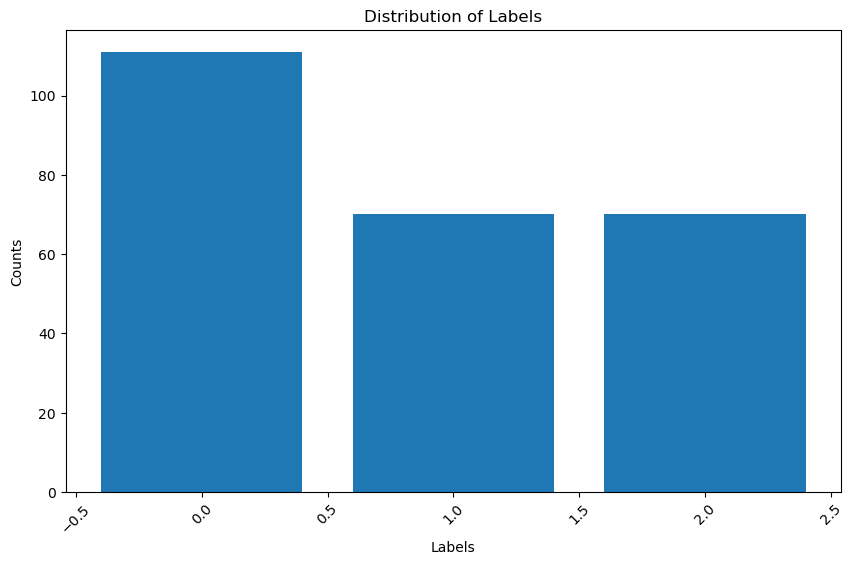

In [6]:
# Get labels and their counts from the trainset object
labels = trainset['label']
label_counts = {}

# Count occurrences of each label
for label in labels:
    label_counts[label] = label_counts.get(label, 0) + 1

# Plot the distribution
plt.figure(figsize=(10, 6))
plt.bar(label_counts.keys(), label_counts.values())
plt.xlabel('Labels')
plt.ylabel('Counts')
plt.title('Distribution of Labels')
plt.xticks(rotation=45)  # Rotate labels for better readability if needed
plt.show()

#### Let's visualise 10 random images from the dataset


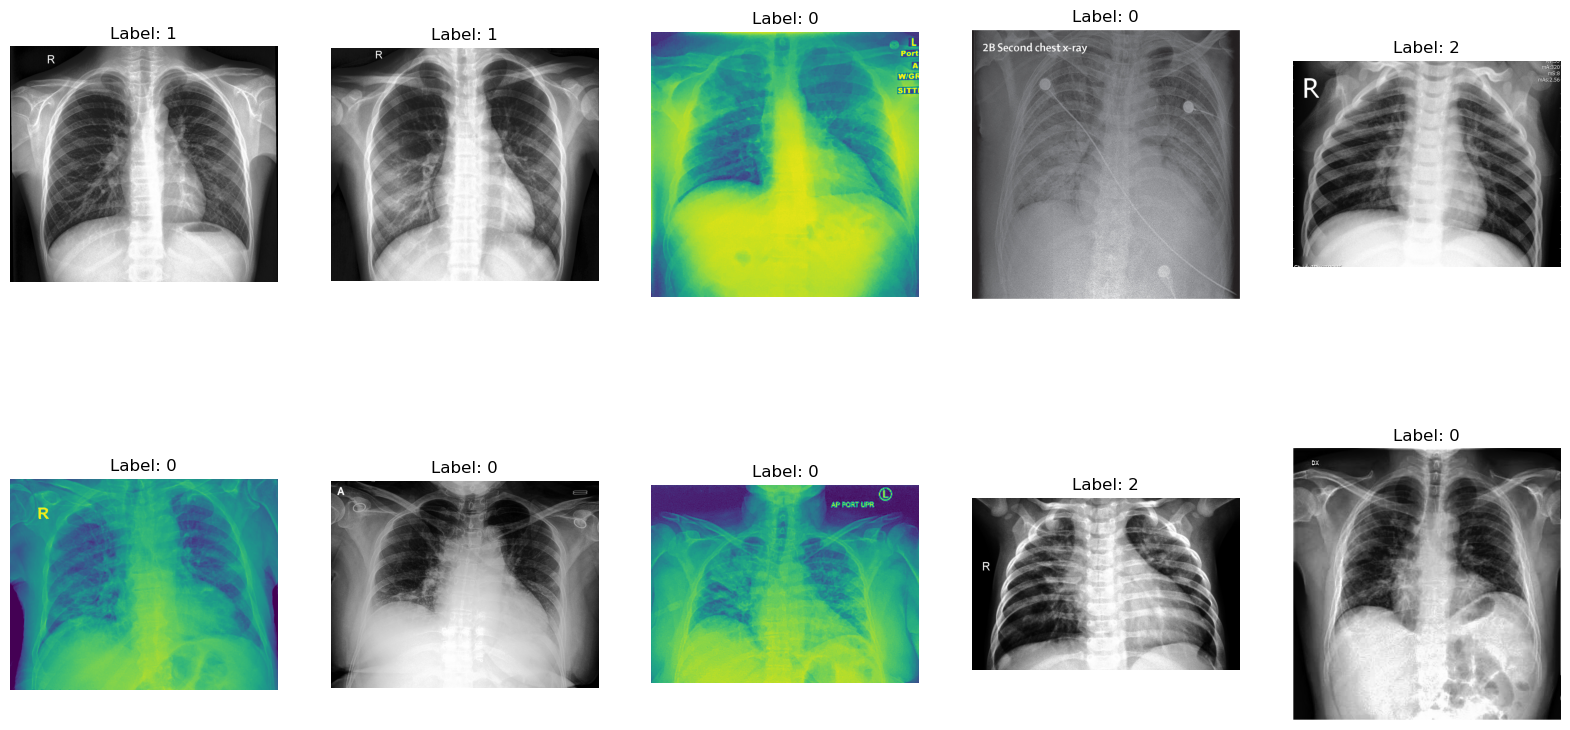

In [7]:
# Function to plot images
def plot_random_images(dataset, num_images=10):
    # Randomly sample num_images from the dataset
    sampled_indices = random.sample(range(len(dataset)), num_images)
    sampled_images = [dataset[i] for i in sampled_indices]
    
    plt.figure(figsize=(20, 10))
    for i, data in enumerate(sampled_images):
        # Get the image and label
        image = data['image']
        label = data['label']
        
        # Create a subplot
        plt.subplot(2, 5, i + 1)
        plt.imshow(image)
        plt.title(f"Label: {label}")
        plt.axis('off')
    
    plt.show()

# Plot 10 random images from the training set
plot_random_images(trainset, num_images=10)

# A CNN architecture

This tutorial is not so much about novel architectural designs so we keep things simple and make use of a typical CNN that is adequate for the image classification task.



In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self, num_classes: int) -> None:
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)  # Change input channels from 1 to 3 for RGB
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        
        # Calculate the size of the input to the first fully connected layer
        # Input image size is 224x224
        # After first conv + pool: (224 - 5 + 1) / 2 = 110.5 -> 110 (rounded down)
        # After second conv + pool: (110 - 5 + 1) / 2 = 53 -> 53 (rounded down)
        # Thus, the input to the fc1 layer is 16 * 53 * 53
        self.fc1 = nn.Linear(16 * 53 * 53, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 53 * 53)  # Flatten the tensor for the fully connected layer
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


#### Alternatively we can use a pretrained model. Note: Takes longer to train

In [9]:
# import torch
# import torch.nn as nn
# from torchvision import models

# class Net(nn.Module):
#     def __init__(self, num_classes):
#         super(Net, self).__init__()
#         # Load the pre-trained DenseNet model
#         self.model = models.densenet121(pretrained=True)
        
#         # Modify the classifier to match the number of classes
#         num_ftrs = self.model.classifier.in_features
#         self.model.classifier = nn.Linear(num_ftrs, num_classes)
        
#     def forward(self, x):
#         return self.model(x)
    
#     def to_device(self, device):
#         self.to(device)




In [10]:
model = Net(num_classes=3)
num_parameters = sum(value.numel() for value in model.state_dict().values())
print(f"{num_parameters = }")

num_parameters = 5406691


## The Training Loop

A minimal training loop in PyTorch can be constructed with three functions:
*  `train()` that will train the model given a dataloader.
* `test()` that will be used to evaluate the performance of the model on held-out data, e.g., a training set.
* `run_centralised()` which will define additional elements (e.g. the optimiser) and run the training loop over N epochs.

Let's construct these functions!


#### Transform the data

In [11]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision.transforms import Compose, Resize, ToTensor, Normalize, RandomRotation, RandomHorizontalFlip
from torch.utils.data import TensorDataset, DataLoader, random_split

transform = Compose(
    [
        RandomRotation(10), #rotate images randomly up to 10 degrees
        RandomHorizontalFlip(p=0.4),
        ToTensor(),
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        
    ]
)
def apply_transforms(batch):
    batch["image"] = [transform(image.convert("RGB").resize((224,224))) for image in batch["image"]]
    return batch


#### Define trainset & testset

In [12]:
trainset = trainset.with_transform(apply_transforms)
testset = testset.with_transform(apply_transforms)

### Centralized training

Let's run this for X epochs, uncomment last line for centralized training! For testing purpose check which epochs achieves highest accuracy

In [13]:
import time #check time w/ gpu


def custom_collate_fn(batch):
    images = torch.stack([item['image'] for item in batch])
    labels = torch.tensor([item['label'] for item in batch])
    return {'image': images, 'label': labels}

def train(net, trainloader, optimizer, epochs, device: str, testloader):
    """Train the network on the training set and print accuracy per epoch."""
    criterion = nn.CrossEntropyLoss()
    net.train()
    for epoch in range(epochs):
        for batch in trainloader:
            images, labels = batch["image"].to(device), batch["label"].to(device)
            optimizer.zero_grad()
            loss = criterion(net(images), labels)
            loss.backward()
            optimizer.step()

        # Evaluate after each epoch
        loss, accuracy = test(net, testloader, device)
        print(f"Epoch {epoch+1}/{epochs} - Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")

    return net

def test(net, testloader, device: str):
    """Validate the network on the entire test set."""
    criterion = nn.CrossEntropyLoss()
    correct, loss = 0, 0.0
    net.eval()
    with torch.no_grad():
        for data in testloader:
            images, labels = data["image"].to(device), data["label"].to(device)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
    accuracy = correct / len(testloader.dataset)
    return loss, accuracy

def run_centralised(epochs: int, lr: float, momentum: float = 0.9):
    """A minimal (but complete) training loop"""

    # Instantiate the model
    model = Net(num_classes=3)

    # Determine device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    # device =  ("cpu")
    model.to(device)  # Send model to device

    # Define optimiser with hyperparameters supplied
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)

    # Now we apply the transform to each batch.
    trainloader = DataLoader(trainset, batch_size=64, shuffle=True, collate_fn=custom_collate_fn)
    testloader = DataLoader(testset, batch_size=128, collate_fn=custom_collate_fn)

    # Start timer
    start_time = time.time()

    # Train for the specified number of epochs
    trained_model = train(model, trainloader, optimizer, epochs, device, testloader)

    # End timer
    end_time = time.time()
    total_time = end_time - start_time
    print(f"Training time: {total_time:.2f} seconds")

    # Final evaluation on the test set
    loss, accuracy = test(trained_model, testloader, device)
    print(f"Final evaluation - Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")

# run_centralised(epochs=10, lr=0.01)  # Adjust the number of epochs as needed

### Run this for FL

In [14]:
from torch.utils.data import DataLoader


def train(net, trainloader, optim, epochs, device: str):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    net.train()
    for _ in range(epochs):
        for batch in trainloader:
            images, labels = batch["image"].to(device), batch["label"].to(device)
            optim.zero_grad()
            loss = criterion(net(images), labels)
            loss.backward()
            optim.step()
    return net

def test(net, testloader, device: str):
    """Validate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, loss = 0, 0.0
    net.eval()
    with torch.no_grad():
        for data in testloader:
            images, labels = data["image"].to(device), data["label"].to(device)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
    accuracy = correct / len(testloader.dataset)
    return loss, accuracy
    

The above centralised formulation has worked just fine for some applications and to showcase the potential of AI in a variety of scenarios. However, as was discussed earlier in the session, centralised training is unsuitable for a larger range of settings were information cannot be collected in order to build a unified (centralised) dataset.

# The Future of AI is Federated

What are the key differences between Federated Learning and Centralised Training? I you could only pick you, probably you'd say:
* Federated Learning is distributed -- the model is trained on-device by the participating clients.
* Data remains private and is owned by a specific _client_ -- the data is never sent to the central server.

The are several more differences. But the above two are the main ones to always consider and that are common to all flavours of Federated Learning (e.g. _cross-device_ or _cross-silo_). The remaining of this tutorial is going to focus in transforming the code we have written so far for the centralised setting and construct a Federated Learning pipeline using Flower and PyTorch.

Let's begin! 🚀

## Data Partition

To start designing a Federated Learning pipeline we need to meet one of the key properties in FL: each client has its own data partition. To accomplish this with the  dataset, we are going to generate N random partitions, where N is the total number of clients in our FL system.

In [24]:
NUM_CLASSES = 3
NUM_CLIENTS =5
NUM_ROUNDS= 10
EPOCHS = 10

In [25]:
def prepare_dataset(num_partitions: int, batch_size: int, val_ratio: float = 0.1):
    """This function partitions the training set into N disjoint
    subsets, each will become the local dataset of a client. This
    function also subsequently partitions each traininset partition
    into train and validation. The test set is left intact and will
    be used by the central server to asses the performance of the
    global model."""

    # # Directly from a directory
    # dataset = load_dataset("imagefolder", data_dir="/Users/allan/dataset/Covid19-dataset")
    # trainset = dataset['train'].with_transform(apply_transforms)
    # testset = dataset['test'].with_transform(apply_transforms)


    # split trainset into `num_partitions` trainsets (one per client)
    # figure out number of training examples per partition
    num_images = len(trainset) // num_partitions
    remainder = len(trainset) % num_partitions

    # a list of partition lenghts (all partitions are of equal size)
    partition_len = [num_images] * num_partitions
    for i in range(remainder):
        partition_len[i] += 1

    trainsets = random_split(
        trainset, partition_len, torch.Generator().manual_seed(42)
    )

    # create dataloaders with train+val support
    trainloaders = []
    valloaders = []
    for trainset_ in trainsets:
        num_total = len(trainset_)
        num_val = int(val_ratio * num_total)
        num_train = num_total - num_val

        for_train, for_val = random_split(
            trainset_, [num_train, num_val], torch.Generator().manual_seed(42)
        )
        

        trainloaders.append(
            DataLoader(for_train, batch_size=batch_size, shuffle=True)
        )
        valloaders.append(
            DataLoader(for_val, batch_size=batch_size, shuffle=False)
        )
    

    # create dataloader for the test set
    testloader = DataLoader(testset, batch_size=128)

    return trainloaders, valloaders, testloader




In [26]:
trainloaders, valloaders, testloader = prepare_dataset(NUM_CLIENTS, 128)

## Defining a Flower Client

You can think of a client in FL as an entity that owns some data and trains a model using this data. The caveat is that the model is being trained _collaboratively_ in Federation by multiple clients (sometimes up to hundreds of thousands) and, in most instances of FL, is sent by a central server.

A Flower Client is a simple Python class with four distinct methods:

* `fit()`: With this method, the client does on-device training for a number of epochs using its own data. At the end, the resulting model is sent back to the server for aggregation.

* `evaluate()`: With this method, the server can evaluate the performance of the global model on the local validation set of a client. This can be used for instance when there is no centralised dataset on the server for validation/test. Also, this method can be use to asses the degree of personalisation of the model being federated.

* `set_parameters()`: This method takes the parameters sent by the server and uses them to initialise the parameters of the local model that is ML framework specific (e.g. TF, Pytorch, etc).

* `get_parameters()`: It extract the parameters from the local model and transforms them into a list of NumPy arrays. This ML framework-agnostic representation of the model will be sent to the server.

Let's start by importing Flower!

In [27]:
import flwr as fl

Now let's define our Flower Client class:

In [28]:
from collections import OrderedDict
from typing import Dict, Tuple
from flwr.common import NDArrays, Scalar


class FlowerClient(fl.client.NumPyClient):
    def __init__(self, trainloader, valloader) -> None:
        super().__init__()

        self.trainloader = trainloader
        self.valloader = valloader
        self.model = Net(num_classes=NUM_CLASSES)
        
        # Determine device
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)  # send model to device


    def set_parameters(self, parameters):
        """With the model parameters received from the server,
        overwrite the uninitialise model in this class with them."""

        params_dict = zip(self.model.state_dict().keys(), parameters)
        state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
        # now replace the parameters
        self.model.load_state_dict(state_dict, strict=True)

    def get_parameters(self, config: Dict[str, Scalar]):
        """Extract all model parameters and convert them to a list of
        NumPy arrays. The server doesn't work with PyTorch/TF/etc."""
        return [val.cpu().numpy() for _, val in self.model.state_dict().items()]

    def fit(self, parameters, config):
        """This method train the model using the parameters sent by the
        server on the dataset of this client. At then end, the parameters
        of the locally trained model are communicated back to the server"""

        # copy parameters sent by the server into client's local model
        self.set_parameters(parameters)

        # Define the optimizer -------------------------------------------------------------- Essentially the same as in the centralised example above
        optim = torch.optim.SGD(self.model.parameters(), lr=0.01, momentum=0.9)

        # do local training  -------------------------------------------------------------- Essentially the same as in the centralised example above (but now using the client's data instead of the whole dataset)
        train(self.model, self.trainloader, optim, epochs=1, device =self.device)

        # return the model parameters to the server as well as extra info (number of training examples in this case)
        return self.get_parameters({}), len(self.trainloader), {}

    def evaluate(self, parameters: NDArrays, config: Dict[str, Scalar]):
        """Evaluate the model sent by the server on this client's
        local validation set. Then return performance metrics."""

        self.set_parameters(parameters)
        loss, accuracy = test(
            self.model, self.valloader, device=self.device)  # <-------------------------- calls the `test` function, just what we did in the centralised setting (but this time using the client's local validation set)
        # send statistics back to the server
        return float(loss), len(self.valloader), {"accuracy": accuracy}

Spend a few minutes to inspect the `FlowerClient` class above. Please ask questions if there is something unclear !

Then keen-eyed among you might have realised that if we were to fuse the client's `fit()` and `evaluate()` methods, we'll end up with essentially the same as in the `run_centralised()` function we used in the Centralised Training part of this tutorial. And it is true!! In Federated Learning, the way clients perform local training makes use of the same principles as more traditional centralised setup. The key difference is that the dataset now is much smaller and it's never _"seen"_ by the entity running the FL workload (i.e. the central server).


Talking about the central server... we should define what strategy we want to make use of so the updated models sent from the clients back to the server at the end of the `fit()` method are aggregate.


## Chosing a Flower Strategy


A strategy sits at the core of the Federated Learning experiment. It is involved in all stages of a FL pipeline: sampling clients; sending the _global model_ to the clients so they can do `fit()`; receive the updated models from the clients and **aggregate** these to construct a new _global model_; define and execute global or federated evaluation; and more.

Flower comes with [many strategies built-in](https://github.com/adap/flower/tree/main/src/py/flwr/server/strategy) and more to be available in the next release (`1.5` already!). For this tutorial, let's use what is arguable the most popular strategy out there: `FedAvg`.

The way `FedAvg` works is simple but performs surprisingly well in practice. It is therefore one good strategy to start your experimentation. `FedAvg`, as its name implies, derives a new version of the _global model_ by taking the average of all the models sent by clients participating in the round. You can read all the details [in the paper](https://arxiv.org/abs/1602.05629).

Let's see how we can define `FedAvg` using Flower. We use one of the callbacks called `evaluate_fn` so we can easily evaluate the state of the global model using a small centralised testset. Note this functionality is user-defined since it requires a choice in terms of ML-framework. (if you recall, Flower is framework agnostic).

> This being said, centralised evaluation of the global model is only possible if there exists a centralised dataset that somewhat follows a similar distribution as the data that's spread across clients. In some cases having such centralised dataset for validation is not possible, so the only solution is to federate the evaluation of the _global model_. This is the default behaviour in Flower. If you don't specify teh `evaluate_fn` argument in your strategy, then, centralised global evaluation won't be performed.

In [29]:
def get_evaluate_fn(testloader):
    """This is a function that returns a function. The returned
    function (i.e. `evaluate_fn`) will be executed by the strategy
    at the end of each round to evaluate the stat of the global
    model."""

    def evaluate_fn(server_round: int, parameters, config):
        """This function is executed by the strategy it will instantiate
        a model and replace its parameters with those from the global model.
        The, the model will be evaluate on the test set (recall this is the
        whole MNIST test set)."""

        model = Net(num_classes=NUM_CLASSES)

        # Determine device
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        model.to(device)  # send model to device

        # set parameters to the model
        params_dict = zip(model.state_dict().keys(), parameters)
        state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
        model.load_state_dict(state_dict, strict=True)

        # call test
        loss, accuracy = test(
            model, testloader, device
        )  # <-------------------------- calls the `test` function, just what we did in the centralised setting
        return loss, {"accuracy": accuracy}

    return evaluate_fn


# # now we can define the strategy
# strategy = fl.server.strategy.FedAvg(
#     # fraction_fit=0.1,  # let's sample 10% of the client each round to do local training
#     # fraction_evaluate=0.1,  # after each round, let's sample 20% of the clients to asses how well the global model is doing
#     min_fit_clients=5,
#     min_evaluate_clients=5,
#     min_available_clients=5,  # total number of clients available in the experiment
#     evaluate_fn=get_evaluate_fn(testloader),
# )  # a callback to a function that the strategy can execute to evaluate the state of the global model on a centralised dataset

So far we have:
* created the dataset partitions (one for each client)
* defined the client class
* decided on a strategy to use

Now we just need to launch the Flower FL experiment... not so fast! just one final function: let's create another callback that the Simulation Engine will use in order to span VirtualClients. As you can see this is really simple: construct a FlowerClient object, assigning each their own data partition.

In [30]:
def generate_client_fn(trainloaders, valloaders):
    def client_fn(cid: str):
        """Returns a FlowerClient containing the cid-th data partition"""

        return FlowerClient(
            trainloader=trainloaders[int(cid)], valloader=valloaders[int(cid)]
        ).to_client()

    return client_fn


client_fn_callback = generate_client_fn(trainloaders, valloaders)

Optional: Add initial parameters

In [31]:
from flwr.common import ndarrays_to_parameters
ndarrays = [val.cpu().numpy() for val in model.state_dict().values()]

# Now convert them to the Parameters type
initial_parameters = ndarrays_to_parameters(ndarrays)

Now we are ready to launch the FL experiment using Flower simulation:


- Visit to view all available strategies: https://github.com/adap/flower/tree/main/src/py/flwr/server/strategy
- DP example: https://flower.ai/docs/framework/how-to-use-differential-privacy.html

### Simulation!

In [ ]:
from flwr.server.strategy import DifferentialPrivacyClientSideFixedClipping
from flwr.server.strategy import DifferentialPrivacyServerSideAdaptiveClipping
from flwr.client.mod import fixedclipping_mod

######################### Now we can define the strategy ################################################

strategy = fl.server.strategy.FedAvg(
    # fraction_fit=0.1,  # let's sample 10% of the client each round to do local training
    # fraction_evaluate=0.1,  # after each round, let's sample 20% of the clients to asses how well the global model is doing
    min_fit_clients=NUM_CLIENTS,
    min_evaluate_clients=NUM_CLIENTS,
    min_available_clients=NUM_CLIENTS,  
    evaluate_fn=get_evaluate_fn(testloader),
    # initial_parameters = initial_parameters
) 

######################### Other strategies ################################################################

med_strategy = fl.server.strategy.FedMedian(
            min_available_clients=NUM_CLIENTS,
            min_fit_clients = NUM_CLIENTS,
            min_evaluate_clients = NUM_CLIENTS,
            evaluate_fn=get_evaluate_fn(testloader),
        )  

prox_strategy = fl.server.strategy.FedProx( 
        # fit_metrics_aggregation_fn=utils.weighted_average,
        evaluate_fn=get_evaluate_fn(testloader),
        min_fit_clients= NUM_CLIENTS,
        min_evaluate_clients= NUM_CLIENTS,
        min_available_clients=NUM_CLIENTS,
        proximal_mu =1.0 #float!
    )

yogi_strategy = fl.server.strategy.FedYogi(
        evaluate_fn=get_evaluate_fn(testloader),
        min_fit_clients=NUM_CLIENTS,
        min_evaluate_clients=NUM_CLIENTS,
        min_available_clients=NUM_CLIENTS,
        initial_parameters=initial_parameters #FedOpt strategies needs initial paramets
    )

######################### Add differential privacy ################################################

# dp_strategy = DifferentialPrivacyClientSideFixedClipping(
#         strategy,
#         noise_multiplier=0.2,
#         clipping_norm=10,
#         num_sampled_clients=NUM_CLIENTS,
#     )

# #Add fixedclipping_mod to the client-side mods
# app = fl.client.ClientApp(
#         client_fn=client_fn_callback,
#         mods=[
#             fixedclipping_mod,
#         ]
#)

dp_strategy = DifferentialPrivacyServerSideAdaptiveClipping(
        strategy,
        noise_multiplier=0.1,
        num_sampled_clients=NUM_CLIENTS,
    )

# FIND THE RIGHT SETTINGS FOR MAXSPEED, set gpu to zero if you have none
client_resources = {"num_cpus": 13, "num_gpus": 0.5} 

# Add the chosen strategy
history = fl.simulation.start_simulation(
    client_fn=client_fn_callback,  # a callback to construct a client
    num_clients=NUM_CLIENTS,  
    config=fl.server.ServerConfig(num_rounds=NUM_ROUNDS),  
    strategy=yogi_strategy,  # the strategy that will orchestrate the whole FL pipeline
    client_resources=client_resources
)

INFO :      Starting Flower simulation, config: num_rounds=10, no round_timeout
2024-07-07 14:32:45,774	INFO worker.py:1621 -- Started a local Ray instance.


You can then use the returned `History` object to either save the results to disk or do some visualisation (or both of course, or neither if you like chaos). Below you can see how you can plot the centralised accuracy obtained at the end of each round (including at the very beginning of the experiment) for the _global model_. This is want the function `evaluate_fn()` that we passed to the strategy reports.

### Plot & save csv 

In [ ]:
%matplotlib inline
import os
import matplotlib.pyplot as plt

print(f"{history.metrics_centralized = }")

global_accuracy_centralised = history.metrics_centralized["accuracy"]
round = [data[0] for data in global_accuracy_centralised]
acc = [100.0 * data[1] for data in global_accuracy_centralised]
plt.plot(round, acc)
plt.grid(True)
plt.ylabel("Accuracy (%)")
plt.xlabel("Round")
plt.title(f"COVID-19 Accuracy Over {NUM_ROUNDS} Rounds {NUM_CLIENTS} clients")
# Specify the directory where you want to save the plot
save_directory = "/gpfs/home4/aduah/flower/metrics"
 
# Ensure the directory exists, create it if it does not
os.makedirs(save_directory, exist_ok=True)

# Construct the full path for the file
save_path = os.path.join(save_directory, f"Image_COVID_{NUM_CLIENTS}C_{NUM_ROUNDS}R_{EPOCHS}E_FedYogi")

# Save the plot to the specified directory
plt.savefig(save_path)
plt.show()

In [ ]:
import csv

# Define the save directory
save_directory = "/gpfs/home4/aduah/flower/metrics"

# Create the directory if it does not exist
os.makedirs(save_directory, exist_ok=True)

# Define the CSV filename
csv_filename = f"Image_COVID_{NUM_CLIENTS}C_{NUM_ROUNDS}R_{EPOCHS}E_FedYogi.csv"

# Create the full path for the CSV file
csv_filepath = os.path.join(save_directory, csv_filename)

# Save the data to the CSV file
with open(csv_filepath, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Round', 'Accuracy'])
    for r, a in zip(round, acc):
        writer.writerow([r, a])

print(f"Data saved to {csv_filepath}")
